In [1]:
import utils
import config
import os
import numpy as np

In [2]:
if __name__ == "__main__":
    df = utils.run_distance_scenario()

In [3]:
df

,distance,recording,target_bin,rr_radar,hr_radar,hr_ref,br_ref,HR_abs_err,RR_abs_err
0,40 cm,1,13,8.5,83.709677,83.733333,9.5,0.023656,1.0
1,40 cm,2,13,9.0,78.483871,81.229508,10.0,2.745637,1.0
2,40 cm,3,13,7.5,75.000000,83.300000,9.0,8.300000,1.5
3,40 cm,4,13,7.0,81.580645,82.295082,9.0,0.714437,2.0
4,80 cm,1,21,6.9,77.709677,86.245902,10.0,8.536224,3.1
5,80 cm,2,22,8.7,74.806452,81.229508,9.0,6.423057,0.3
6,80 cm,3,21,9.8,71.903226,82.901639,9.0,10.998414,0.8
7,80 cm,4,21,6.7,75.580645,81.650000,9.0,6.069355,2.3
8,120 cm,1,30,4.5,87.483871,85.262295,9.0,2.221576,4.5
9,120 cm,2,30,5.3,79.064516,83.918033,9.0,4.853517,3.7


## Wyjaśnienie zmiennych
* rr_radar: odległość radaru od badanej osoby 
* recording: numer badania
* target_bin: bin odległości wybrany jako klatka piersiowa
* rr_radar: częstość oddechu wykryta przez radar 
* hr_radar: częstość akcji serca wykryta przez radar
* hr_ref: referencyjna częstość serca (ground truth)
* br_ref: referencyjna częstość oddechu (ground truth)
* HR_abs_err: bezwzględny błąd estymacji HR
* RR_abs_err: bezwzględny błąd estymacji RR

## Wykresy pomocnicze wizualizacji sygnału 

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
import config
from utils import (
    open_memmap,
    pick_target_bin_motion,
    extract_displacement,
    bandpass
)

def plot_rr_hr_signals(dist="40 cm", rec="1"):
    radar_path = os.path.join(config.BASE_RADAR, dist, rec, "data_Raw_0.bin")
    mem = open_memmap(radar_path)

    target_bin = pick_target_bin_motion(mem)
    print(f"Wybrany target_bin (klatka piersiowa): {target_bin}")
    disp_rr = extract_displacement(mem, target_bin, mode="RR")
    disp_hr = extract_displacement(mem, target_bin, mode="HR")

    t = np.arange(config.OBS_FRAMES) / config.FS

    rr_sig = bandpass(disp_rr, config.FS, *config.RR_BAND)
    hr_sig = bandpass(disp_hr, config.FS, *config.HR_BAND)
    plt.figure(figsize=(12, 8))

    plt.subplot(3, 1, 1)
    plt.plot(t, disp_rr, color="black")
    plt.title("Pełny sygnał przemieszczenia klatki piersiowej (radar)")
    plt.ylabel("Przemieszczenie [m]")
    plt.grid(True)

    plt.subplot(3, 1, 2)
    plt.plot(t, rr_sig, color="green")
    plt.title("Składowa oddechowa (RR) wykryta przez algorytm")
    plt.ylabel("Amplituda")
    plt.grid(True)

    plt.subplot(3, 1, 3)
    plt.plot(t, hr_sig, color="red")
    plt.title("Składowa serca (HR) wykryta przez algorytm")
    plt.xlabel("Czas [s]")
    plt.ylabel("Amplituda")
    plt.grid(True)

    plt.tight_layout()
    plt.show()

Wybrany target_bin (klatka piersiowa): 21


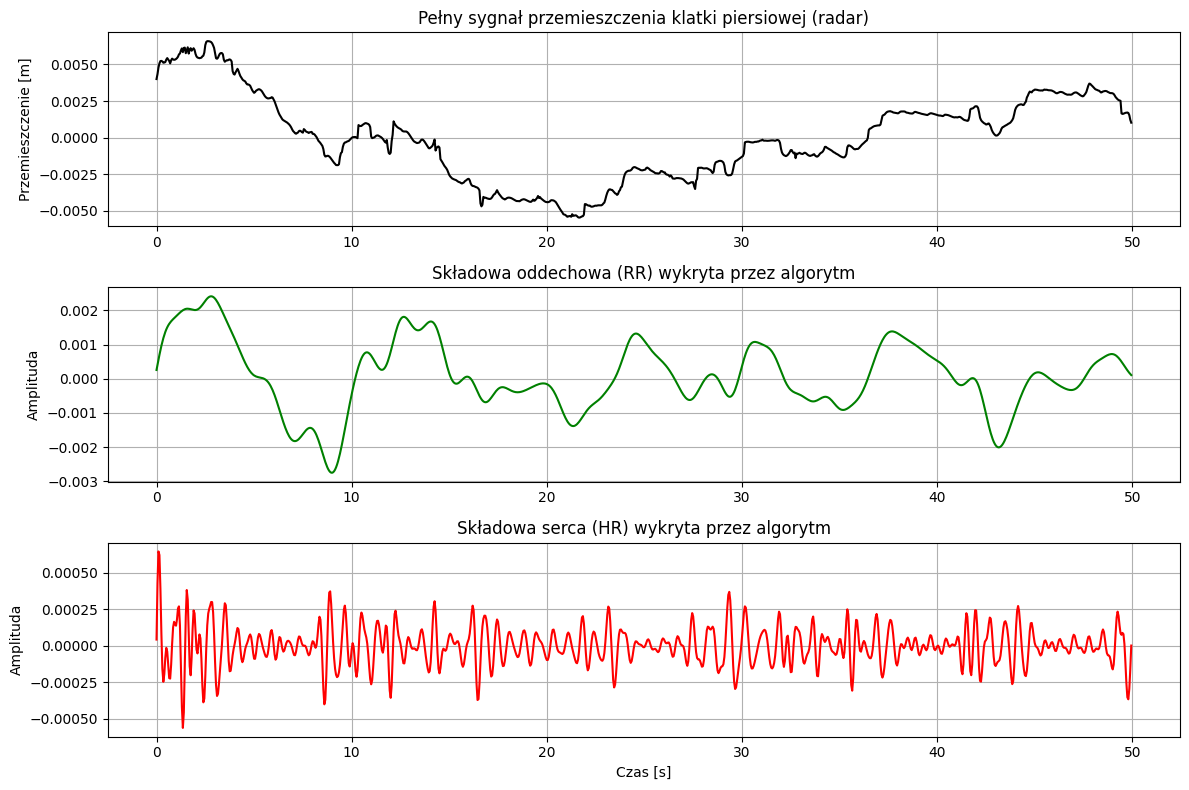

In [5]:
plot_rr_hr_signals("80 cm", "1")

## Sparwdzenie poprawności target binu

In [6]:
def visualize_target_bin_selection(dist="40 cm", rec="1"):
    radar_path = os.path.join(config.BASE_RADAR, dist, rec, "data_Raw_0.bin")
    mem = utils.open_memmap(radar_path)

    range_map = utils.build_range_map(mem)

    roi = utils.find_motion_based_roi(range_map)
    if roi is None:
        print("Nie wykryto ROI")
        return

    roi_start, roi_end = roi
    target_bin = utils.pick_target_bin_motion(mem)

    rm_dc = range_map - range_map.mean(axis=0, keepdims=True)
    motion_profile = np.var(rm_dc, axis=0)
    motion_profile /= np.max(motion_profile)

    print(f"ROI (klatka piersiowa): biny {roi_start}–{roi_end}")
    print(f"target_bin = {target_bin}")

    fig, axs = plt.subplots(1, 3, figsize=(18, 5))

    im = axs[0].imshow(range_map.T, aspect="auto", origin="lower")
    axs[0].axhspan(roi_start, roi_end, color="cyan", alpha=0.3, label="ROI")
    axs[0].axhline(target_bin, color="red", linewidth=2, label="target_bin")
    axs[0].set_title("Mapa zasięgu (Range map)")
    axs[0].set_xlabel("Czas (ramki)")
    axs[0].set_ylabel("Bin odległości")
    axs[0].legend()
    plt.colorbar(im, ax=axs[0], label="Amplituda |FFT|")

    axs[1].plot(motion_profile, color="black")
    axs[1].axvspan(roi_start, roi_end, color="cyan", alpha=0.3)
    axs[1].axvline(target_bin, color="red", linestyle="--")
    axs[1].set_title("Profil ruchu (wariancja w czasie)")
    axs[1].set_xlabel("Bin odległości")
    axs[1].set_ylabel("Znormalizowana energia ruchu")
    axs[1].grid(True)

    axs[2].imshow(
        range_map[:, roi_start:roi_end].T,
        aspect="auto",
        origin="lower"
    )
    axs[2].set_title("Zoom na ROI (klatka piersiowa)")
    axs[2].set_xlabel("Czas (ramki)")
    axs[2].set_ylabel("Bin odległości")

    plt.tight_layout()
    plt.show()

ROI (klatka piersiowa): biny 9–17
target_bin = 13


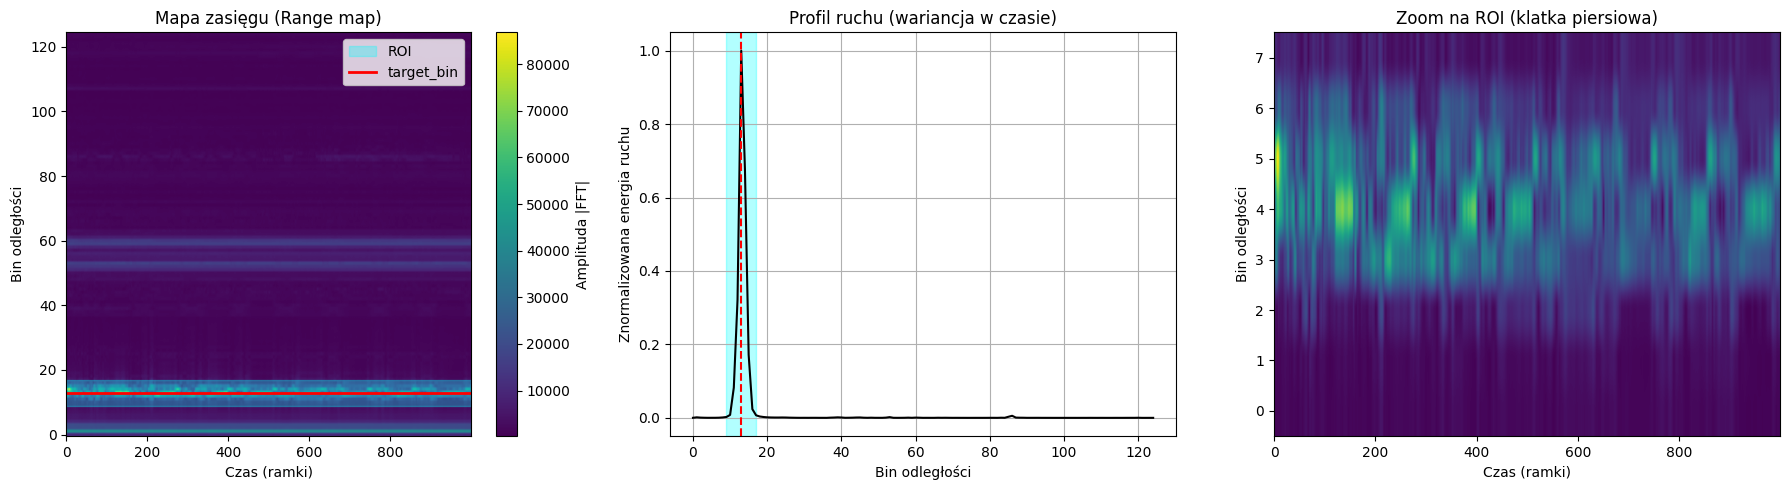

In [7]:
visualize_target_bin_selection("40 cm", "1")

In [8]:
def visualize_rr_on_full_signal(dist="80 cm", rec="1"):

    radar_path = os.path.join(config.BASE_RADAR, dist, rec, "data_Raw_0.bin")
    mem = utils.open_memmap(radar_path)

    target_bin = utils.pick_target_bin_motion(mem)
    print(f"target_bin = {target_bin}")

    disp = utils.extract_displacement(mem, target_bin, mode="RR")
    rr_sig = utils.bandpass(disp, config.FS, *config.RR_BAND)

    t = np.arange(len(rr_sig)) / config.FS

    rr_series = utils.estimate_bpm_series(
        rr_sig,
        config.RR_BAND,
        config.W_RR
    )

    rr_radar = np.nanmean(rr_series)
    print(f"RR radar = {rr_radar:.2f} BPM")

    rr_hz = rr_radar / 60.0
    rr_period = 1 / rr_hz

    breath_times = np.arange(0, t[-1], rr_period)

    plt.figure(figsize=(15, 6))
    plt.plot(t, rr_sig, color="black", label="Sygnał RR")

    for bt in breath_times:
        plt.axvline(bt, color="red", linestyle="--", alpha=0.6)

    plt.title(
        f"Cały sygnał RR (50 s)\n"
        f"RR radar = {rr_radar:.2f} BPM (czerwone linie = oddechy wg algorytmu)"
    )
    plt.xlabel("Czas [s]")
    plt.ylabel("Amplituda")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

target_bin = 13
RR radar = 8.52 BPM


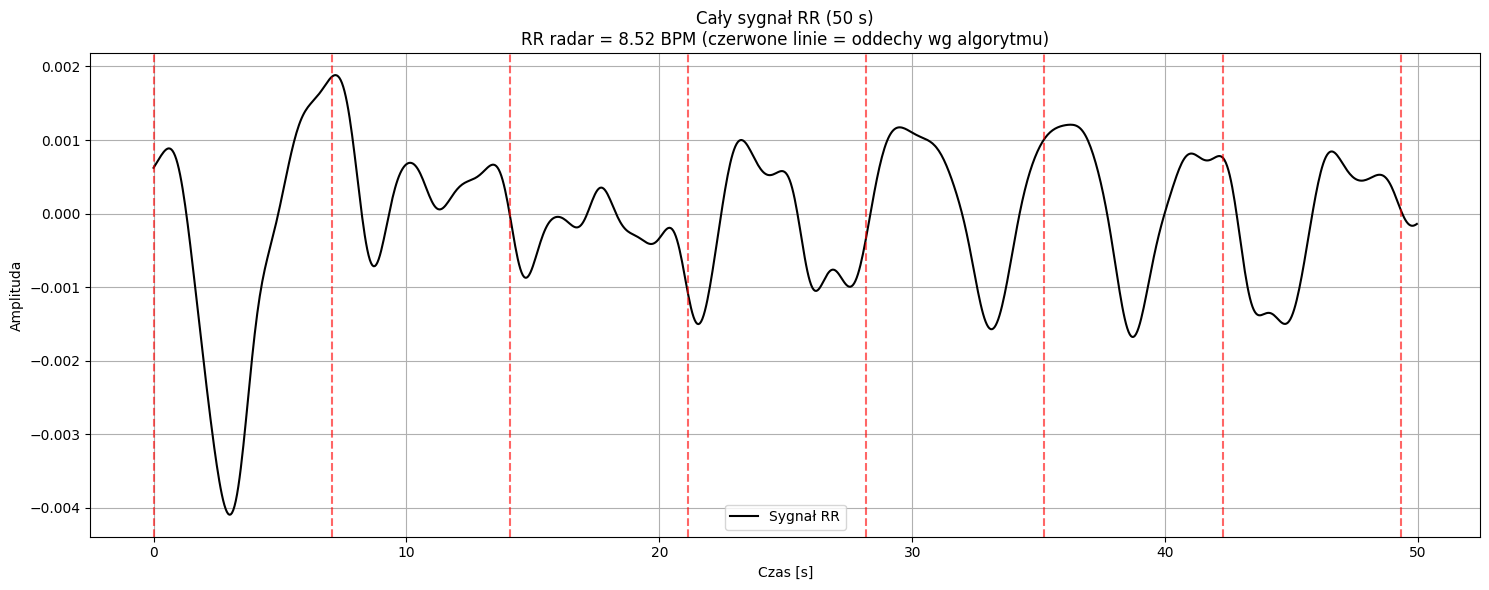

In [9]:
visualize_rr_on_full_signal(dist="40 cm", rec="1")